Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [73]:
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

In [24]:
digits = load_digits()
print(f"X shape = {digits.data.shape}; y shape = {digits.target.shape}")

X shape = (1797, 64); y shape = (1797,)


Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [25]:
X = np.abs(digits.data - 16)
y = digits.target

<Figure size 640x480 with 0 Axes>

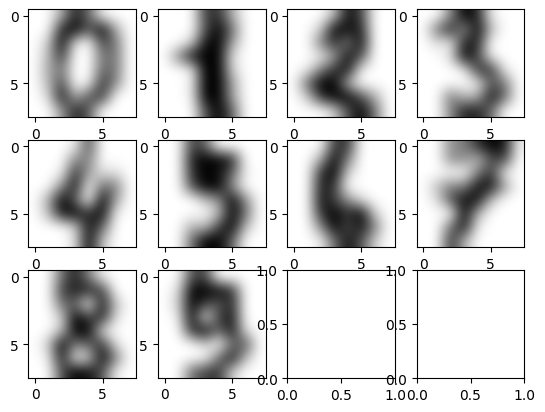

In [26]:
plt.gray()

fig, axs = plt.subplots(3, 4)
for i, ax in enumerate(axs.flat):
    if i == 10:
        break
    ax.imshow(X[i].reshape(8, 8), interpolation='bicubic')

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [27]:
ac = AgglomerativeClustering(n_clusters=10)
ac_clusters = ac.fit_predict(X)
ac_clusters.shape

(1797,)

In [34]:
km = KMeans(n_clusters=10, n_init=100)
km_clusters = km.fit_predict(X)
km_clusters.shape

(1797,)

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [35]:
def plot_mean(clusters):
    plt.gray()
    fig, axs = plt.subplots(3, 4)
    for i, ax in enumerate(axs.flat):
        if i == 10:
            break
        ax.imshow(np.mean(X[clusters == i], axis=0).reshape(8, 8), interpolation='bicubic')

<Figure size 640x480 with 0 Axes>

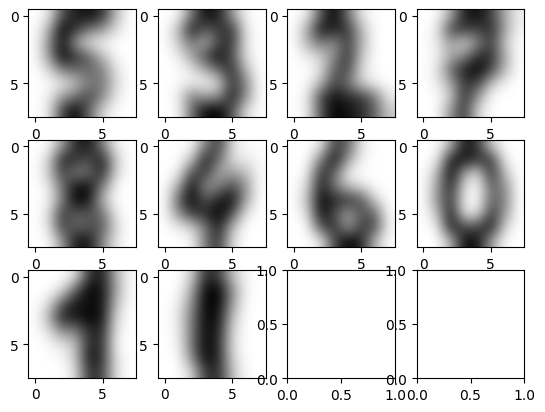

In [36]:
plot_mean(ac_clusters)

<Figure size 640x480 with 0 Axes>

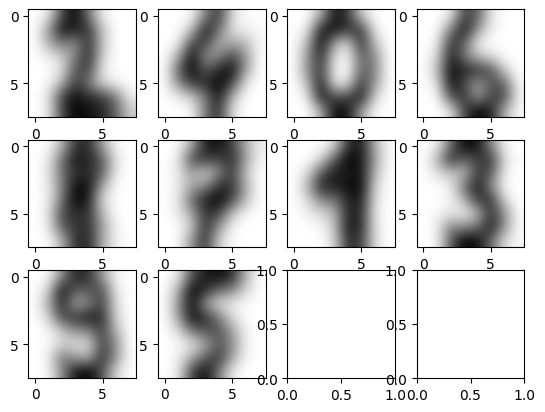

In [37]:
plot_mean(km_clusters)

**Заметны проблемы с девяткой у `AgglomerativeClustering` и с восьмеркой у `Kmeans`. В целом особой разницы не видно, но кажется `KMeans` дали чуть лучший результат**

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [44]:
km_scores = []
for i in range(2, 21):
    km = KMeans(n_clusters=i, n_init=100)
    km_clusters = km.fit_predict(X)
    km_scores.append([i, silhouette_score(X, km_clusters)])

In [45]:
ac_scores = []
for i in range(2, 21):
    ac = AgglomerativeClustering(n_clusters=i)
    ac_clusters = ac.fit_predict(X)
    ac_scores.append([i, silhouette_score(X, ac_clusters)])

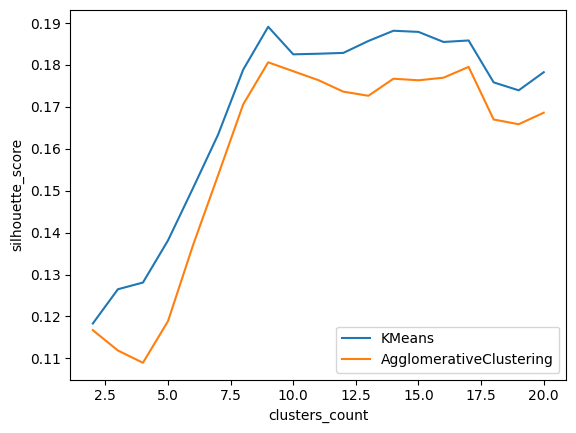

In [60]:
plt.xlabel("clusters_count")
plt.ylabel('silhouette_score')

arr = np.array(km_scores)
plt.plot(arr[:,0], arr[:,1], label="KMeans")

arr = np.array(ac_scores)
plt.plot(arr[:,0], arr[:,1], label="AgglomerativeClustering")

plt.legend();

**По графику явно видны более лучшие показатели у `KMeans`. Наилучший результат у обоих моделей достигается при числе кластеров равным девяти**

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [61]:
km_scores = []
for i in range(2, 21):
    km = KMeans(n_clusters=i, n_init=100)
    km_clusters = km.fit_predict(X)
    km_scores.append([i, v_measure_score(y, km_clusters)])

In [62]:
ac_scores = []
for i in range(2, 21):
    ac = AgglomerativeClustering(n_clusters=i)
    ac_clusters = ac.fit_predict(X)
    ac_scores.append([i, v_measure_score(y, ac_clusters)])

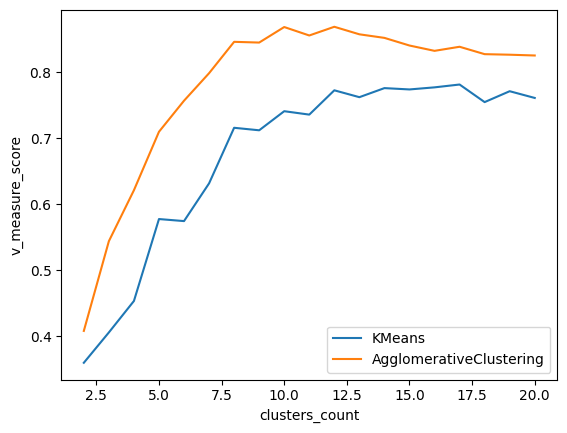

In [66]:
plt.xlabel("clusters_count")
plt.ylabel('v_measure_score')

arr = np.array(km_scores)
plt.plot(arr[:,0], arr[:,1], label="KMeans")

arr = np.array(ac_scores)
plt.plot(arr[:,0], arr[:,1], label="AgglomerativeClustering")

plt.legend();

**Показатель `V-меры` у `AgglomerativeClustering` выше. Максимальные значения у `AgglomerativeClustering` и `KMeans` достигаются при 12 и 17 кластерах соответственно**

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [70]:
km_slh_scores = []
km_v_scores = []

ac_slh_scores = []
ac_v_scores = []

for n in [2, 5, 10, 20]:
    svd = TruncatedSVD(n_components=n, random_state=123)
    X_svd = svd.fit_transform(X)

    km = KMeans(n_clusters=10, n_init=100)
    km_clusters = km.fit_predict(X_svd)
    km_slh_scores.append([n, silhouette_score(X_svd, km_clusters)])
    km_v_scores.append([n, v_measure_score(y, km_clusters)])

    ac = AgglomerativeClustering(n_clusters=10)
    ac_clusters = ac.fit_predict(X_svd)
    ac_slh_scores.append([n, silhouette_score(X_svd, ac_clusters)])
    ac_v_scores.append([n, v_measure_score(y, ac_clusters)])


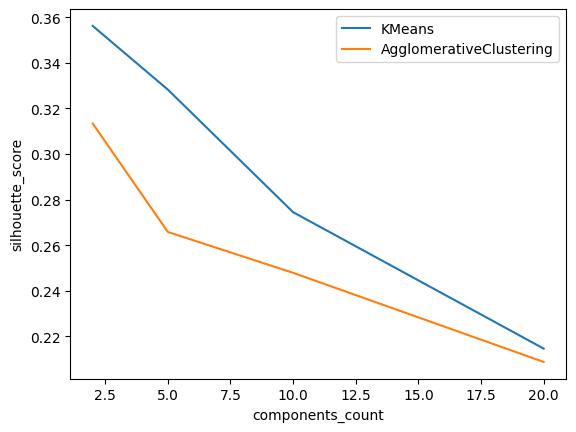

In [71]:
plt.xlabel("components_count")
plt.ylabel('silhouette_score')

arr = np.array(km_slh_scores)
plt.plot(arr[:,0], arr[:,1], label="KMeans")

arr = np.array(ac_slh_scores)
plt.plot(arr[:,0], arr[:,1], label="AgglomerativeClustering")

plt.legend();

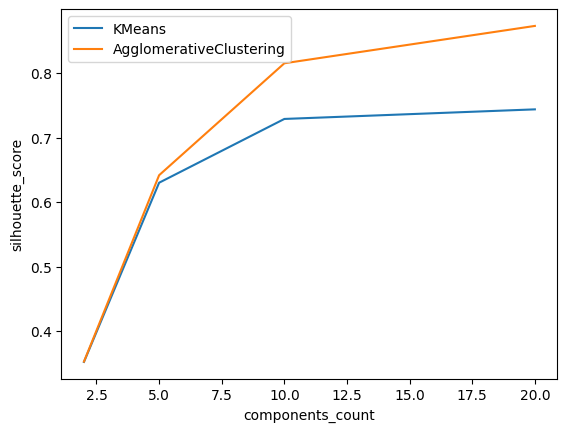

In [72]:
plt.xlabel("components_count")
plt.ylabel('silhouette_score')

arr = np.array(km_v_scores)
plt.plot(arr[:,0], arr[:,1], label="KMeans")

arr = np.array(ac_v_scores)
plt.plot(arr[:,0], arr[:,1], label="AgglomerativeClustering")

plt.legend();

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [74]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=123)
X_tsne = tsne.fit_transform(X)

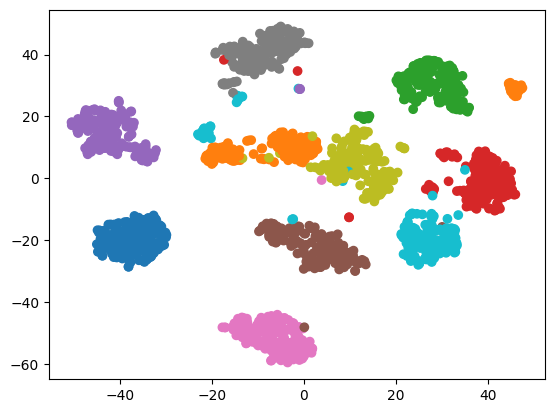

In [81]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], cmap='tab10', c=y)

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [86]:
km = KMeans(n_clusters=10, n_init=100)
km_clusters = km.fit_predict(X_tsne)

In [87]:
print(f'silhouetter={silhouette_score(X_tsne, km_clusters)};\nv_score={v_measure_score(y, km_clusters)}')

silhouetter=0.6386203765869141;
v_score=0.9068009116540512


In [85]:
ac = AgglomerativeClustering(n_clusters=10)
ac_clusters = ac.fit_predict(X_tsne)

In [88]:
print(f'silhouetter={silhouette_score(X_tsne, ac_clusters)};\nv_score={v_measure_score(y, ac_clusters)}')

silhouetter=0.6399413347244263;
v_score=0.9209572754528726


Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<Figure size 640x480 with 0 Axes>

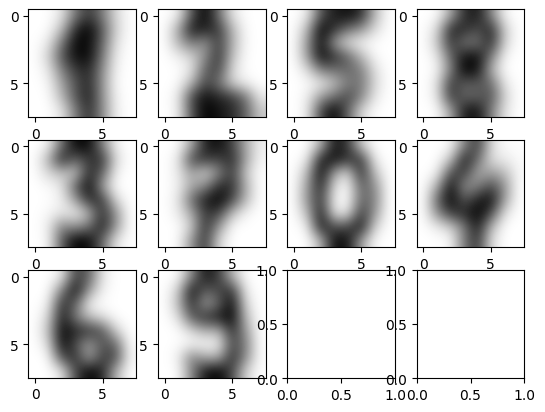

In [89]:
plot_mean(ac_clusters)

<Figure size 640x480 with 0 Axes>

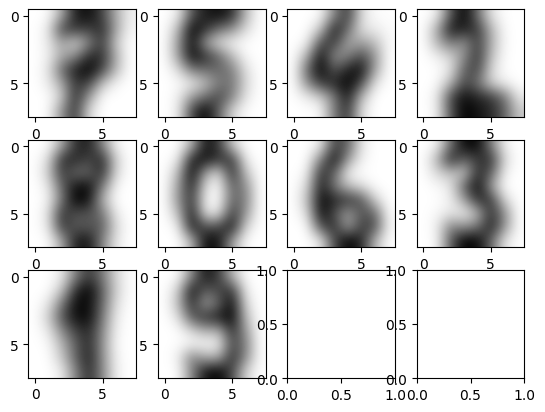

In [90]:
plot_mean(km_clusters)

**Стало лучше. Единицу чуть подразмыло, но теперь нет двух цифр, которые можно перепутать между собой**

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

1. Ощутимой разницы между результатами двух моделей нет
2. Получилось добиться лучшей кластеризации с помощью `TSNE` + `AgglomerativeClustering`

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.